In [1]:
import numpy as np
import pandas as pd
from environment.tetris import Tetris
from agents.DumbAgent import DumbAgent
from multiprocessing import Pool, cpu_count
from tqdm import tqdm
import matplotlib.pyplot as plt
from skopt import dummy_minimize,gp_minimize,forest_minimize
from skopt.space import Real
from skopt.utils import use_named_args
from skopt.plots import plot_convergence, plot_objective, plot_evaluations
import seaborn as sns
import os
from time import time
from functools import partial

sns.set_theme()
np.random.seed(42)
os.makedirs("results", exist_ok=True)

C:\Users\canic\AppData\Local\Temp\ipykernel_53564\1624430455.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
max_steps = 250
num_games = 1

In [3]:
def play_game(env, agent):
    env.reset()
    total_reward = 0
    for _ in range(max_steps):
        next_states = env.get_possible_states()
        best_action = agent.act(next_states)
        done, score, reward = env.step(*best_action)
        total_reward += reward

        if done:
            break

    return total_reward


def play_single_game(weights):
    env = Tetris(10, 20,use_level=False)
    agent = DumbAgent(5, None, weights=weights)
    return play_game(env, agent)

In [4]:
space = [
    Real(-1, 1, name="cleared_lines"),
    Real(-1, 1, name="holes"),
    Real(-1, 1, name="bumpiness"),
    Real(-1, 1, name="max_height"),
    Real(-1, 1, name="check_pillar"),
]

@use_named_args(space)
def objective_function_named(**params):
    # Convert dictionary to list in the expected order
    weights = np.array([params[dim.name] for dim in space])

    if num_games == 1:
        return -play_single_game(weights)

    with Pool(processes=min(num_games, cpu_count())) as pool:
        results = pool.map(play_single_game, [weights for _ in range(num_games)])

    mean_reward = np.mean(results)
    print(f"Average reward: {mean_reward:.2f}")

    return -mean_reward

def run(minimizer, n_iter=1,**args):
    return [minimizer(objective_function_named, space, n_calls=250, random_state=n, **args)
            for n in range(n_iter)]


# Random search
start = time()
dummy_res = run(dummy_minimize)
end = time()
print(f"Dummy took: {(end-start):.2f}s, {((end-start)/60):.2f} min")

# Gaussian processes
start = time()
gp_res = run(gp_minimize,acq_func = "EI",n_initial_points = 100)
end = time()
print(f"Gaussian took: {(end-start):.2f}s, {((end-start)/60):.2f} min")

# Random forest
start = time()
rf_res = run(forest_minimize, base_estimator="RF")
end = time()
print(f"Random forest took: {(end-start):.2f}s, {((end-start)/60):.2f} min")

# Extra trees
start = time()
et_res = run(forest_minimize, base_estimator="ET")
end = time()
print(f"Extra trees took: {(end-start):.2f}s, {((end-start)/60):.2f} min")

# result = gp_minimize(
#         objective_function_named,
#         space,
#         n_calls=200,  # Total evaluations (includes n_initial_points)
#         n_initial_points=10,  # Initial random evaluations
#         acq_func="EI",  # Expected Improvement
#         n_jobs=-1,  # Use all available cores
#         verbose=False,
#     )



# optimal_weights = [gp_res.x[i] for i in range(len(space))]
# for name, value in zip([dim.name for dim in space], optimal_weights):
#     print(f"{name}: {value:.6f}")

Dummy took: 59.37s, 0.99 min
Gaussian took: 537.49s, 8.96 min
Random forest took: 471.15s, 7.85 min
Extra trees took: 422.95s, 7.05 min


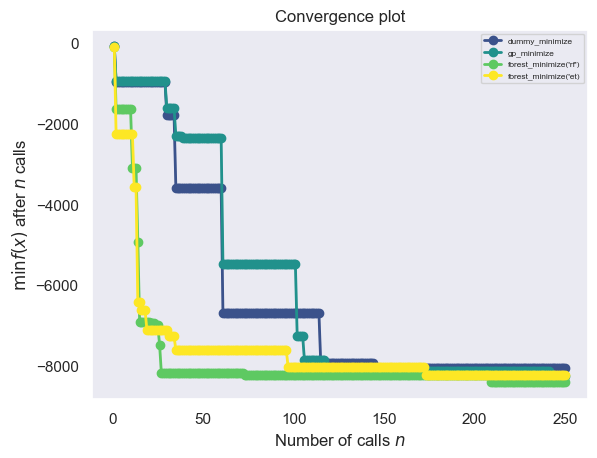

In [9]:
true_min = -(int(max_steps/10) * 1200) -20*max_steps

plot = plot_convergence(("dummy_minimize", dummy_res),
                        ("gp_minimize", gp_res),
                        ("forest_minimize('rf')", rf_res),
                        ("forest_minimize('et)", et_res))
#                        true_minimum=true_min) #, yscale="log")

plot.legend(loc="best", prop={'size': 6}, numpoints=1)
plt.savefig("results/convergence_comarison_between_models_no_min.png")


In [ ]:
# np.save("gp_res/optimal_weights.npy", np.array(optimal_weights))

NameError: name 'optimal_weights' is not defined

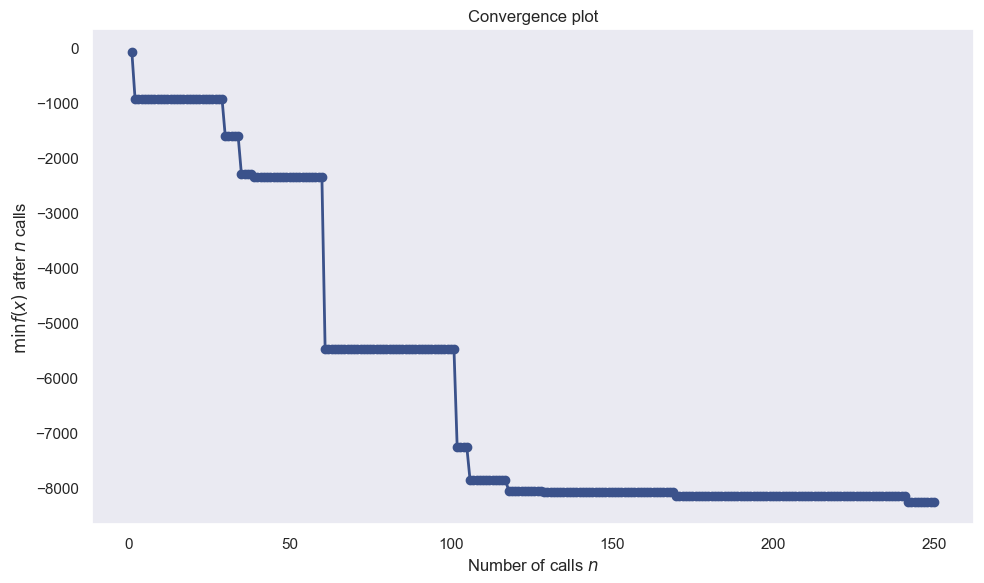

<Figure size 1200x1000 with 0 Axes>

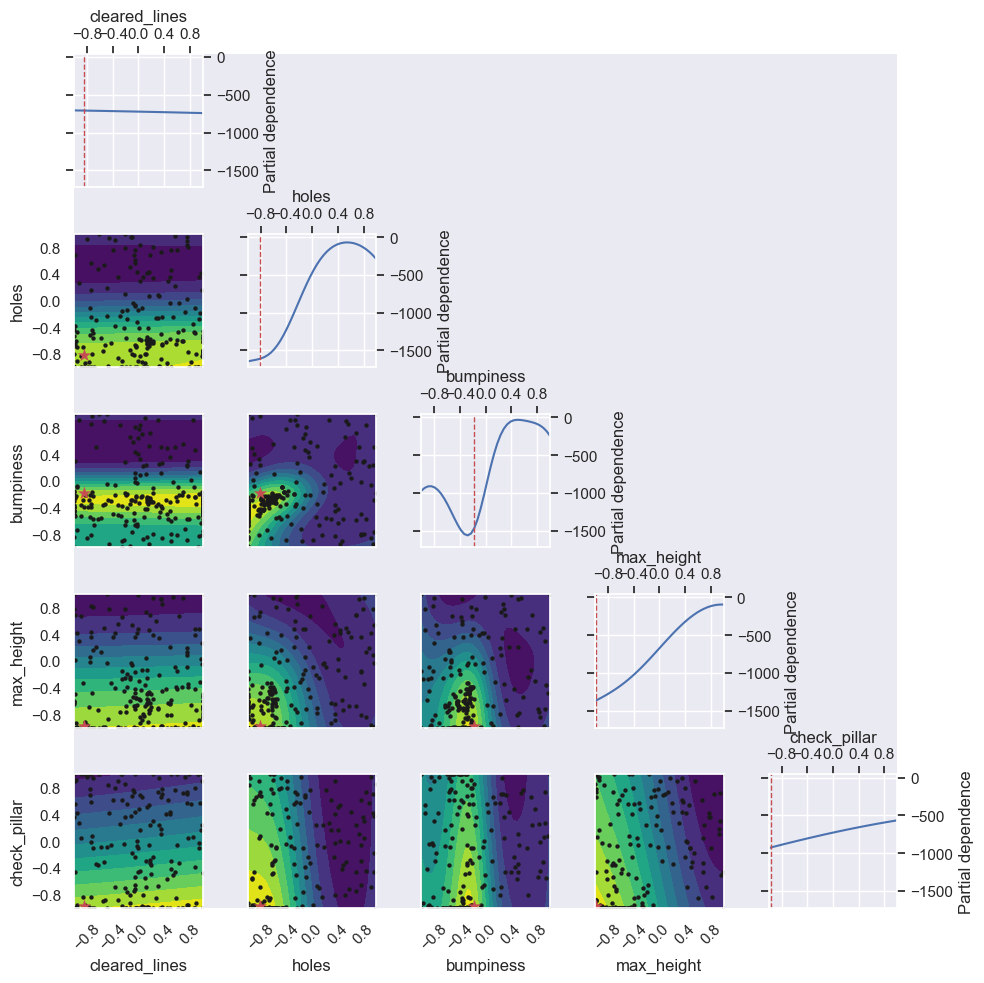

<Figure size 1200x1000 with 0 Axes>

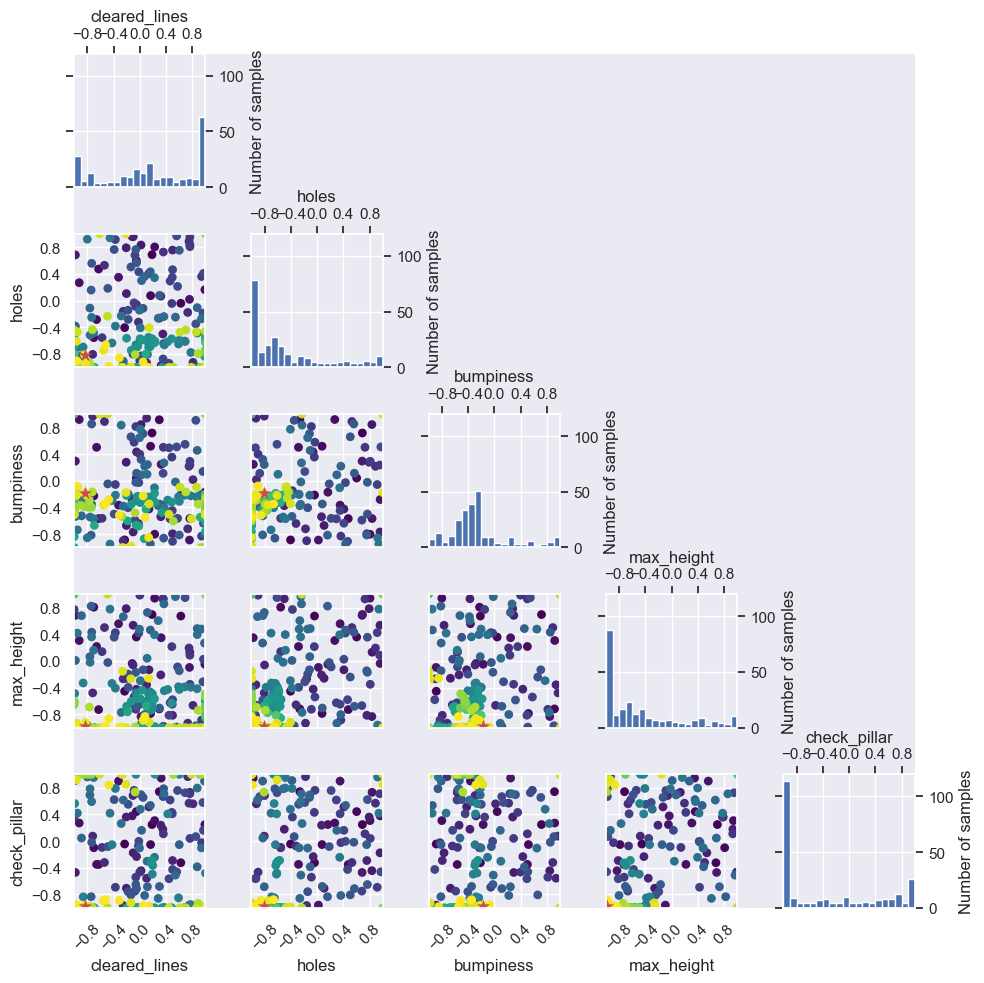

In [11]:
plt.figure(figsize=(10, 6))
plot_convergence(gp_res[0])
plt.tight_layout()
plt.savefig("results/convergence.png")

# Plot and save objective function
plt.figure(figsize=(12, 10))
plot_objective(gp_res[0])
plt.tight_layout()
plt.savefig("results/objective.png")

# Plot and save evaluations
plt.figure(figsize=(12, 10))
plot_evaluations(gp_res[0])
plt.tight_layout()
plt.savefig("results/evaluations.png")

# Save detailed report
with open("results/report.txt", "w") as f:
    f.write(f"Number of evaluations: {len(gp_res[0].x_iters)}\n")
    f.write(f"Best score: {-gp_res[0].fun:.6f}\n")
    f.write("Optimal weights:\n")
    for name, value in zip([dim.name for dim in space], gp_res[0].x):
        f.write(f"{name}: {value:.6f}\n")
    f.write("\nAll evaluations:\n")
    for i, (x, y) in enumerate(zip(gp_res[0].x_iters, gp_res[0].func_vals)):
        f.write(f"Iteration {i+1}: score={-y:.6f}, params={x}\n")

eval_df = pd.DataFrame(
    [list(x) + [-y] for x, y in zip(gp_res[0].x_iters, gp_res[0].func_vals)],
    columns=[dim.name for dim in space] + ["reward"],
)
eval_df.to_csv("results/evaluations.csv", index=False)